In [553]:
import sys
sys.path.insert(0, r'../../../quetzal')
from quetzal.model import stepmodel
import pandas as pd
import numpy as np
from numba import jit
import matplotlib.pyplot as plt

In [554]:

#city='Chicago-Sketch'
#city = 'Winnipeg'
city = 'chicago-regional'

data_dir = 'TransportationNetworks/'+city+'/'
city = 'ChicagoRegional'


In [555]:
mat = []
value=[]
row=[1]
with open(data_dir+city+'_trips.tntp') as f:
    i=0
    
    for line in f:
        if i>=5:
            if (line[0:6]=='Origin'):
                row.append(int(line.split()[1]))
                mat.append(value)
                value=[]
            else:
                for l in line.split(';')[:-1]:
                    r = l.split(':')
                    value.append( (int(r[0]) , float(r[1]) ) )

            
        i+=1
    mat.append(value)

In [556]:
len(mat)

1790

In [557]:
volume=pd.DataFrame()
for i in range(len(row)):
    temp_df = pd.DataFrame(mat[i],columns=['destination','V'])
    temp_df['origin'] = row[i]
    volume=volume.append(temp_df)


In [558]:
volume = volume.reset_index(drop=True)
volume = volume[['origin','destination','V']]

In [559]:
def drop_volumes(volumes,threshold=10e-2,log=False):
    v = volumes.copy()
    #v = v.loc[v['origin'] != v['destination']]
    v = v.loc[v['V'] > threshold]
    if log:
        print('Volume reduction', 100*round(1-v['V'].sum() / volumes['V'].sum(),3),'%')
        print('OD number reduction',round(100*(1-len(v)/len(volumes)),3),'%')
    # add volume on remaining OD such that the total volume is maintained.
    v['V']=v['V'] * (volumes['V'].sum() / v['V'].sum())
    return v

In [560]:
v = volume.copy()
v = drop_volumes(v,threshold=6e-3,log=True)

Volume reduction -0.0 %
OD number reduction 26.734 %


In [561]:
print(100*(v.loc[v['origin'] == v['destination']]['V'].sum())/sum(v['V']),'% des volumes Origine = Destination')
print('les résultats vont différé de la reference si on les élimine.')

3.2664826010056247 % des volumes Origine = Destination
les résultats vont différé de la reference si on les élimine.


In [562]:
len(v)

2297945

In [563]:
# Importing the networks into a Pandas dataframe consists of a single line of code
# but we can also make sure all headers are lower case and without trailing spaces

if city=='Chicago':
    skip=8
else:
    skip=6
net = pd.read_csv(data_dir+city+'_net.tntp', skiprows=skip, sep='\t')

trimmed= [s.strip().lower() for s in net.columns]
net.columns = trimmed

# And drop the silly first andlast columns
net.drop(['~', ';'], axis=1, inplace=True)

In [564]:
net = net.rename(columns={'init_node':'a','term_node':'b','free_flow_time':'time','b':'alpha','power':'beta'})
net['a'] = 'rnode_'+net['a'].astype(str)
net['b'] = 'rnode_'+net['b'].astype(str)


In [565]:
zone_dict = {'rnode_'+str(r):'zone_'+str(r) for r in row}


In [566]:
net['a'] = net['a'].apply(lambda x: zone_dict.get(x,x))
net['b'] = net['b'].apply(lambda x: zone_dict.get(x,x))

In [567]:
road_links = net[~(net['a'].str.contains('zone') | net['b'].str.contains('zone'))]
zone_to_road = net[net['a'].str.contains('zone') | net['b'].str.contains('zone')]

In [568]:
road_links = road_links.reset_index(drop=True)

In [569]:
road_links.index = 'rlink_'+road_links.index.astype(str)
road_links.index.name='index'

In [570]:
road_links['limit']=1000

In [571]:
road_links['vdf']='limited_bpr'

In [572]:
#Toll: 0.1 minutes/cent Distance: 0.25 minutes/mile/


In [573]:
if city=='Winnipeg':
    road_links['penalty'] =0
elif city=='Barcelona':
    road_links['penalty'] =0
elif city == 'ChicagoRegional':
    road_links['penalty'] = road_links['toll']*0.1 + road_links['length']*0.25
elif city  == 'Chicago-Sketch':
    road_links['penalty'] = road_links['toll']*100*0.1 + road_links['length']*0.04
else: 
    stop

In [574]:
zone_to_road = zone_to_road.reset_index(drop=True)
zone_to_road['direction'] = 'access'
zone_to_road['vdf']='limited_bpr'

In [575]:
Vzone_dict = {r:'zone_'+str(r) for r in row}
v['origin'] = v['origin'].apply(lambda x: Vzone_dict.get(x))
v['destination'] = v['destination'].apply(lambda x: Vzone_dict.get(x))

In [576]:
from numba import jit
@jit(nopython=True)
def limited_bpr(mat,der=False):
    #columns in mat : 'alpha','beta','limit','flow','time','penalty','capacity'
    #der return the second derivative (for the find beta...)
    jam_time=[]
    for i in range(mat.shape[0]):
        alpha = mat[i,0]
        beta = mat[i,1]
        limit = mat[i,2]
        V = mat[i,3]
        t0 = mat[i,4]
        penalty = mat[i,5]
        Q = mat[i,6]
        res =  t0 * (1 + alpha*np.power(V/Q, beta))
        if res > t0*limit: # we plateau the curve at limit.
            if der == False:
                jam_time.append(t0*limit + penalty)
            else:
                jam_time.append(0)
                
        else:
            if der == False:
                jam_time.append(res + penalty)     
            else:
                der = (t0*alpha*beta/(Q**beta)) *np.power(V,beta-1)
                jam_time.append(der)
    return jam_time

@jit(nopython=True)
def free_flow(mat,der=False):
    #columns in mat : 'alpha','beta','limit','flow','time','penalty','capacity'
    #der return the derivative (for the find beta...)
    t0 = mat[:,4]
    penalty = mat[:,5]
    if der == False:
        return t0
    else:
        return t0*0



vdf ={'limited_bpr':limited_bpr,'free_flow':free_flow}


## Import Model

In [577]:
self =stepmodel.StepModel()

In [578]:
self.volumes = v
self.road_links = road_links

In [579]:
self.zone_to_road = zone_to_road

In [580]:
self.zones = [z[1] for z  in zone_dict.items()]

In [581]:
%%time
self.step_road_pathfinder(method='bfw',tolerance=0.000001,maxiters=100,vdf=vdf,volume_column='V',log=True,num_cores=4)

iteration | Phi |  Rel Gap (%)
0 0.1281 85.123
1 0.1281 73.582
2 0.1 57.476
3 0.1094 43.874
4 0.0844 30.169
5 0.1 21.563
6 0.0906 14.525
7 0.0969 10.351
8 0.0938 7.627
9 0.1172 5.53
10 0.1187 4.029
11 0.1469 3.203
12 0.2 2.494
13 0.2969 1.782
14 0.4 1.255
15 0.7125 0.769
16 0.8 0.241
17 0.8 0.059
18 0.0453 1.204
19 0.0578 0.569
20 0.0328 0.63
21 0.0469 0.521
22 0.0563 0.43
23 0.0469 0.349
24 0.0531 0.31
25 0.0641 0.262
26 0.0875 0.224
27 0.1156 0.184
28 0.1125 0.166
29 0.1156 0.146
30 0.1266 0.12
31 0.175 0.103
32 0.1859 0.088
33 0.1938 0.069
34 0.2625 0.054
35 0.2906 0.042
36 0.2781 0.033
37 0.3297 0.024
38 0.4828 0.018
39 0.4203 0.012
40 0.4359 0.009
41 0.3781 0.007
42 0.2609 0.005
43 0.2766 0.005
44 0.2547 0.005
45 0.2172 0.006
46 0.1688 0.006
47 0.1484 0.008
48 0.1438 0.008
49 0.1281 0.009
50 0.1234 0.009
51 0.1016 0.01
52 0.0625 0.011
53 0.0453 0.012
54 0.05 0.013
55 0.0609 0.013
56 0.0469 0.014
57 0.0641 0.013
58 0.0328 0.014
59 0.0516 0.014
60 0.0469 0.014
61 0.0469 0.012
62 0.0

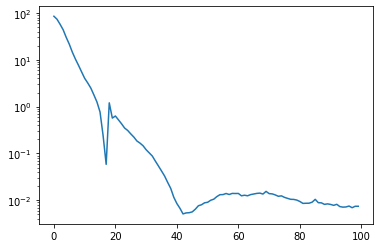

In [582]:
plt.semilogy(self.relgap)

In [583]:
net = pd.read_csv(data_dir+city+'_flow.tntp', skiprows=skip, sep='\t')


In [584]:
# Importing the networks into a Pandas dataframe consists of a single line of code
# but we can also make sure all headers are lower case and without trailing spaces
if city=='Winnipeg':
    skip=0
elif city=='Barcelona':
    skip=0
elif city == 'ChicagoRegional':
    skip=6
else:
    skip=0
net = pd.read_csv(data_dir+city+'_flow.tntp', skiprows=skip, sep='\t')

trimmed= [s.strip().lower() for s in net.columns]
net.columns = trimmed
if city == 'ChicagoRegional':
    # And drop the silly first andlast columns
    net.drop([';'], axis=1, inplace=True)

In [585]:
if city == 'ChicagoRegional':
    net = net.rename(columns = {'tail':'a','head':'b'})
else:
    net = net.rename(columns = {'from':'a','to':'b'})
net['a'] = 'rnode_'+net['a'].astype(str)
net['b'] = 'rnode_'+net['b'].astype(str)


In [586]:
zone_dict = {'rnode_'+str(r):'zone_'+str(r) for r in row}

net['a'] = net['a'].apply(lambda x: zone_dict.get(x,x))
net['b'] = net['b'].apply(lambda x: zone_dict.get(x,x))

In [587]:
rlinks_dict = self.road_links.reset_index().set_index(['a','b'])['index'].to_dict()

In [588]:
net['index'] = net.set_index(['a','b']).index.map(rlinks_dict.get)

In [589]:
net = net[~net['index'].isna()]

In [590]:
net = net.set_index('index')

In [591]:
self.road_links['cost'] = self.road_links['jam_time']+self.road_links['penalty']

In [592]:
assert len(net) == len(self.road_links)

In [593]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [625]:
relgap = str(round(self.relgap[-1],3))
relgap

'0.007'

In [626]:
#relgap=' (1 iteration)'
#relgap='0'

In [627]:
x = self.road_links['cost']
y = net['cost']

regr = linear_model.LinearRegression(fit_intercept=False)#

regr.fit(x[:, np.newaxis], y)
y_pred = regr.predict(x[:, np.newaxis])
r2 = r2_score(y, y_pred)
slope = regr.coef_[0]
intercept=0

Text(0.5, 1.0, 'comparaison temps écoulement sur chaque liens ChicagoRegional (relgap=0.007%)')

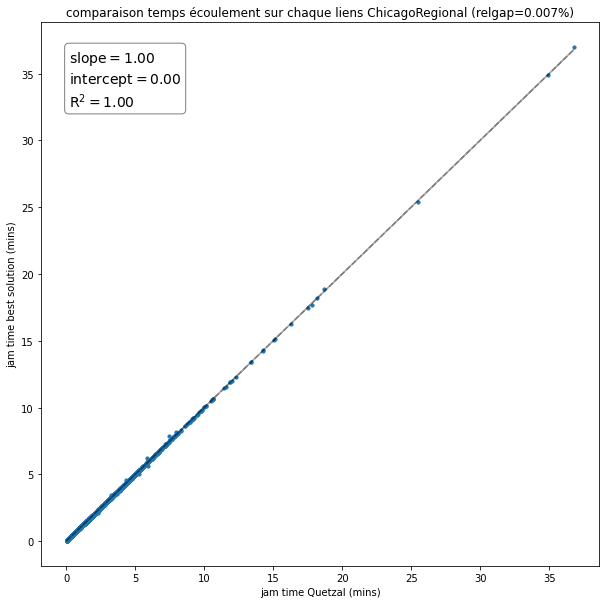

In [628]:
fig, ax = plt.subplots(figsize=(10,10))

plt.scatter(x,y,alpha=1,s=10)
maxvalue = self.road_links['cost'].max()
plt.plot([0,maxvalue],[0,maxvalue],'--k',alpha=0.3)
textstr = '\n'.join((
    r'$\mathrm{slope}=%.2f$' % (slope, ),
    r'$\mathrm{intercept}=%.2f$' % (intercept, ),
    r'$\mathrm{R^2}=%.2f$' % (r2, )))
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.plot(self.road_links['cost'],self.road_links['cost']*slope+intercept,'k',alpha=0.3)

plt.xlabel('jam time Quetzal (mins)')
plt.ylabel('jam time best solution (mins)')
plt.title('comparaison temps écoulement sur chaque liens '+city+' (relgap='+relgap+'%)')
#plt.title('comparaison temps écoulement sur chaque liens '+city +relgap)

In [632]:
x = self.road_links['flow']
y = net['volume']

regr = linear_model.LinearRegression(fit_intercept=False)#

regr.fit(x[:, np.newaxis], y)
y_pred = regr.predict(x[:, np.newaxis])
r2 = r2_score(y, y_pred)
slope = regr.coef_[0]
intercept=0

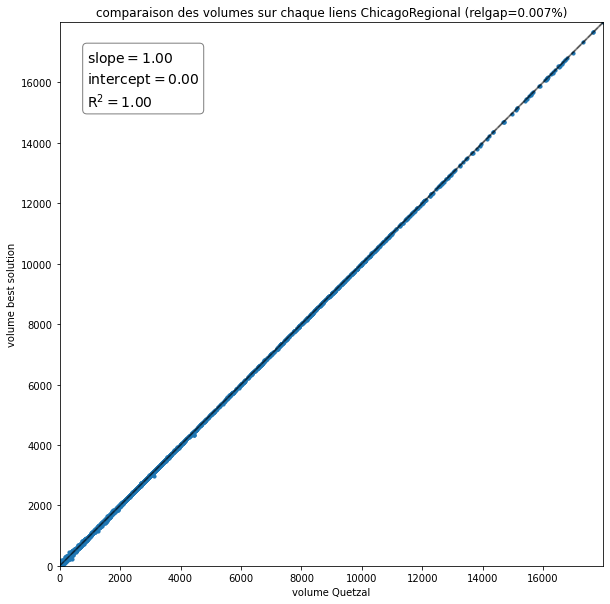

In [633]:
fig, ax = plt.subplots(figsize=(10,10))

plt.scatter(x,y,alpha=1,s=10)
maxvalue = x.max()
plt.plot([0,maxvalue],[0,maxvalue],'--k',alpha=0.3)
textstr = '\n'.join((
    r'$\mathrm{slope}=%.2f$' % (slope, ),
    r'$\mathrm{intercept}=%.2f$' % (intercept, ),
    r'$\mathrm{R^2}=%.2f$' % (r2, )))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.plot(x,x*slope+intercept,'k',alpha=0.5)

plt.xlabel('volume Quetzal')
plt.ylabel('volume best solution')
plt.xlim([0,maxvalue])
plt.ylim([0,maxvalue])
plt.title('comparaison des volumes sur chaque liens '+city+' (relgap='+relgap+'%)')
#plt.title('comparaison des volumes sur chaque liens '+city+relgap)
ax.set_aspect('equal', adjustable='box')

In [635]:
slope

1.0000916175871017

In [650]:
len(self.road_links['flow'])

35436

In [649]:
len(net['volume'])

35436

# objective function

In [636]:
print('quetzal', (self.road_links['flow']*self.road_links['cost']).sum())

quetzal 38129532.112039514


In [637]:
print('best solution', (net['volume']*net['cost']).sum())

best solution 38138978.12884268


In [639]:
print('diff=',100*(1-(self.road_links['flow']*self.road_links['cost']).sum()/(net['volume']*net['cost']).sum()), '%')

diff= 0.0247673568265383 %


In [647]:
(self.road_links['flow']*self.road_links['cost']).sum()-(net['volume']*net['cost']).sum()

-9446.01680316776

# OD time

In [603]:
car=self.copy()
car.road_links['time'] = car.road_links['cost']
#pour le shortest path sur le reseau a vide
#car.road_links['time'] = car.road_links['time'] + car.road_links['penalty']

In [604]:
car.analysis_car_los()
car.analysis_car_time()

In [605]:
ref = self.copy()
ref.road_links['time'] = net['cost']
ref.road_links['volume'] = net['volume']

In [606]:
ref.analysis_car_los()
ref.analysis_car_time()

In [607]:
odt_quetzal = car.car_los['time'].values
odt_ref =ref.car_los['time'].values

In [608]:
x = odt_quetzal
y = odt_ref

regr = linear_model.LinearRegression(fit_intercept=False)#

regr.fit(x[:, np.newaxis], y)
y_pred = regr.predict(x[:, np.newaxis])
r2 = r2_score(y, y_pred)
slope = regr.coef_[0]
intercept=0

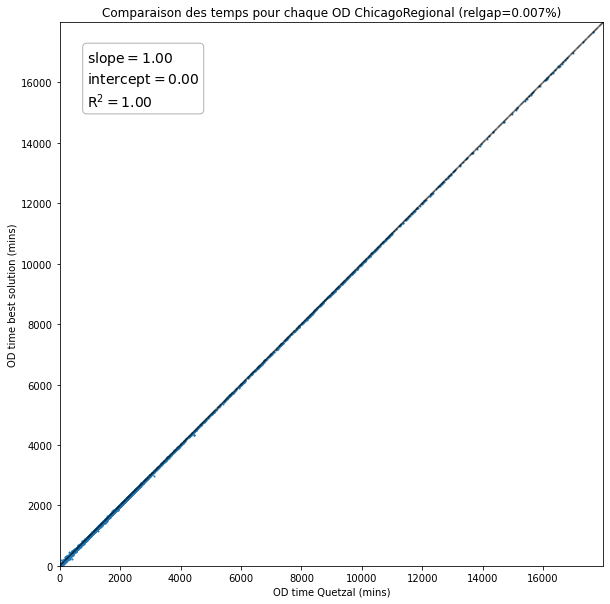

In [641]:
fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(x,y,alpha=1,s=1)
maxvalue = x.max()
plt.plot([0,maxvalue],[0,maxvalue],'--k',alpha=0.3)

textstr = '\n'.join((
    r'$\mathrm{slope}=%.2f$' % (slope, ),
    r'$\mathrm{intercept}=%.2f$' % (intercept, ),
    r'$\mathrm{R^2}=%.2f$' % (r2, )))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=0.3)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.plot(x,x*slope+intercept,'k',alpha=0.5)

plt.xlabel('OD time Quetzal (mins)')
plt.ylabel('OD time best solution (mins)')
plt.xlim([0,maxvalue])
plt.ylim([0,maxvalue])
#plt.title('Comparaison des temps pour chaque OD '+city+' (relgap=0.01%)')
plt.title('Comparaison des temps pour chaque OD '+city+' (relgap='+relgap+'%)')

ax.set_aspect('equal', adjustable='box')


In [642]:
car.car_los['diff_time'] = car.car_los['time'] - ref.car_los['time']

In [643]:
print('positif = ref plus long')
print('median',np.median((np.array(odt_ref) - np.array(odt_quetzal))))
print('mean',np.mean((np.array(odt_ref) - np.array(odt_quetzal))))
print('std',np.std(np.array(odt_ref) - np.array(odt_quetzal)))

positif = ref plus long
median 0.01426146048564192
mean 0.019607030258636405
std 0.031048147004472736


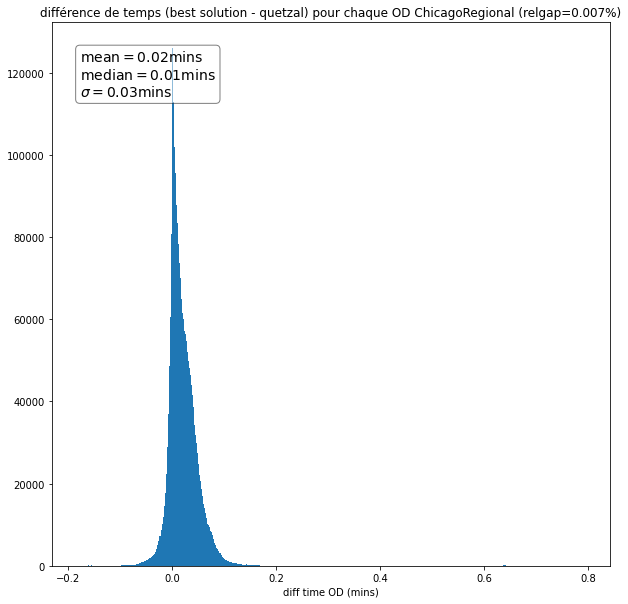

In [644]:
fig, ax = plt.subplots(figsize=(10,10))

plt.hist(odt_ref-odt_quetzal,bins=500)
plt.xlabel('diff time OD (mins)')
mean = np.mean((np.array(odt_ref) - np.array(odt_quetzal)))
median =np.median((np.array(odt_ref) - np.array(odt_quetzal)))
sigma = np.std(np.array(odt_ref) - np.array(odt_quetzal))
textstr = '\n'.join((
    r'$\mathrm{mean}=%.2f$mins' % (mean, ),
    r'$\mathrm{median}=%.2f$mins' % (median, ),
    r'$\sigma=%.2f$mins' % (sigma, )))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.title('différence de temps (best solution - quetzal) pour chaque OD ' +city+' (relgap='+relgap+'%)')
#plt.title('différence de temps (best solution - quetzal) pour chaque OD' +city+relgap)


plt.show()